In [15]:
# Reading the uploaded FASTA file and modifying the headers to only retain the second string

input_file_path = 'data1/fungi_ITS_sorted90.fasta'
output_file_path = 'data1/fungi_ITS_cleaned.fasta'

# Open the input file and create the output file
with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            # Splitting the line and keeping only the second string
            header_parts = line.strip().split()
            if len(header_parts) > 1:
                modified_header = '>' + header_parts[1] + '\n'
                outfile.write(modified_header)
            else:
                outfile.write(line)
        else:
            outfile.write(line)

output_file_path


'data1/fungi_ITS_cleaned.fasta'

# vectorization

In [16]:
import itertools

def generate_all_kmers(k):
    return [''.join(p) for p in itertools.product('ACGT', repeat=k)]

def kmer_vector(sequence, k):
    # gen all possible k-mers comb
    all_kmers = generate_all_kmers(k)
    vector = [0] * len(all_kmers)
    kmer_to_index = {kmer: idx for idx, kmer in enumerate(all_kmers)}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if kmer in kmer_to_index:
            vector[kmer_to_index[kmer]] += 1
    return vector

input_file_path = 'data1/fungi_ITS_cleaned.fasta'
output_file_path = 'data1/fungi_ITS_kmer_vector.txt'

############################# k
k = 6


with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    current_sequence = ""
    current_header = ""
    
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k)
                vector_str = ' '.join(map(str, vector))
                outfile.write(f"{current_header}\t{vector_str}\n")
            current_header = line.strip()
            current_sequence = ""
        else:
            current_sequence += line.strip()
    
    if current_sequence:
        vector = kmer_vector(current_sequence, k)
        vector_str = ' '.join(map(str, vector))
        outfile.write(f"{current_header}\t{vector_str}\n")

output_file_path


'data1/fungi_ITS_kmer_vector.txt'

In [17]:

from collections import defaultdict


input_file = 'data1/fungi_ITS_kmer_vector.txt'
output_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'

genera_count = defaultdict(int)
with open(input_file, 'r') as f:
    for line in f:
        if line.startswith('>'):
            genus = line.split()[0][1:]
            genera_count[genus] += 1

# Filtering the sequences and saving to a new file
with open(input_file, 'r') as f, open(output_file, 'w') as out:
    write_line = False
    for line in f:
        if line.startswith('>'):
            genus = line.split()[0][1:]
            write_line = genera_count[genus] >= 10
        if write_line:
            out.write(line)

print("Filtering complete. The results are saved in 'fungi_ITS_kmer_vector_filtered.txt'.")


Filtering complete. The results are saved in 'fungi_ITS_kmer_vector_filtered.txt'.


In [18]:
# File paths
input_file_path = 'data1/fungi_ITS_kmer_vector.txt'
output_file_path = 'data1/fungi_ITS_kmer_vector_with_header.txt'

# k value to consider
k = 6

# Generate all possible k-mers for the header row
all_kmers = generate_all_kmers(k)
header_row = "ID\t" + "\t".join(all_kmers) + "\n"

# Open the input file and create the output file with the header row
with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    # Write the header row to the output file
    outfile.write(header_row)
    # Write the rest of the content from the input file
    for line in infile:
        outfile.write(line)

output_file_path


'data1/fungi_ITS_kmer_vector_with_header.txt'

# genera at least with x numbers of data

In [19]:
# Importing necessary libraries
import pandas as pd

# Load the file into a DataFrame
file_path = 'data1/fungi_ITS_kmer_vector_with_header.txt'
df = pd.read_csv(file_path, sep='\t')

# Filter out genera with fewer than 10 sequences
filtered_df = df.groupby('ID').filter(lambda x: len(x) >= 10)

# Save the filtered DataFrame to a new file
filtered_file_path = 'data1/fungi_ITS_kmer_vector_filtered.txt'
filtered_df.to_csv(filtered_file_path, sep='\t', index=False)

print("Filtering complete. The results are saved in 'filtered_fungi_ITS_kmer_vector.txt'.")


Filtering complete. The results are saved in 'filtered_fungi_ITS_kmer_vector.txt'.


# train test split

In [20]:
import random

input_file_path = 'data1/fungi_ITS_kmer_vector_filtered.txt'
train_file_path = 'data1/fungi_ITS_train.txt'
test_file_path = 'data1/fungi_ITS_test.txt'

data_by_class = {}

with open(input_file_path, 'r') as infile:
    for line in infile:
        line = line.strip()
        if line.startswith('>'):
            parts = line.split('\t')
            if len(parts) == 2:
                label = parts[0][1:]  # remove '>'
                vector_str = parts[1]
                
                if label not in data_by_class:
                    data_by_class[label] = []
                data_by_class[label].append(line)

test_data = []
train_data = []

for label, samples in data_by_class.items():
    if len(samples) > 1:
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([sample for sample in samples if sample != test_sample])
    else:
        train_data.extend(samples)

with open(train_file_path, 'w') as train_file:
    for line in train_data:
        train_file.write(line + '\n')

with open(test_file_path, 'w') as test_file:
    for line in test_data:
        test_file.write(line + '\n')


train_file_path, test_file_path


('data1/fungi_ITS_train.txt', 'data1/fungi_ITS_test.txt')

# start

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load data and labels from input file
input_file_path = 'data1/fungi_ITS_train.txt'

labels = []
data_vectors = []

with open(input_file_path, 'r') as infile:
    for line in infile:
        line = line.strip()
        if line.startswith('>'):
            parts = line.split('\t')
            if len(parts) == 2:
                label = parts[0][1:]  # remove '>'
                vector_str = parts[1]
                vector = list(map(int, vector_str.split()))
                labels.append(label)
                data_vectors.append(vector)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#
data_tensor = torch.tensor(data_vectors, dtype=torch.float32)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the DataLoader
kmer_dataset = KmerDataset(data_tensor, labels_tensor)
train_dataloader = DataLoader(kmer_dataset, batch_size=32, shuffle=True)

# Create a dictionary to map class indices to class names
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Print dataset information
print(len(kmer_dataset))
print(set(labels))
print(len(set(labels)))
print(len(label_encoder.classes_))

for batch_idx, (data, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Data:", data)
    print("Labels:", labels)
    # Map label indices to class names for each batch
    label_names = [class_mapping[idx.item()] for idx in labels]
    print("Label Names:", label_names)
    print("print len of label names:", len(label_names))
    print()

1612
{'Scolecobasidium', 'Hydnellum', 'Ophiocordyceps', 'Cortinarius', 'Colacogloea', 'Otidea', 'Verrucaria', 'Orbilia', 'Hygrophorus', 'Scytinostroma', 'Suhomyces', 'Mucor', 'Fomitiporia', 'Clavulina', 'Cladophialophora', 'Geastrum', 'Cantharellus', 'Mortierella', 'Cyberlindnera', 'Metschnikowia', 'Tricholoma', 'Malassezia', 'Crepidotus', 'Hymenochaete', 'Sugiyamaella', 'Saturnispora', 'Amanita', 'Inosperma', 'Trichoderma', 'Wickerhamomyces', 'Tremella', 'Spathaspora', 'Apiospora', 'Hygrocybe', 'Trechispora', 'Genea', 'Clavaria', 'Xylodon', 'Xylaria', 'Saccharomycopsis', 'Perenniporia', 'Absidia', 'Backusella', 'Elsinoe', 'Kazachstania', 'Tomentella', 'Roussoella', 'Starmerella', 'Ramaria', 'Exophiala', 'Russula', 'Leucoagaricus', 'Lecanora', 'Phyllosticta', 'Cyphellophora', 'Lepiota', 'Arthroderma', 'Phylloporus', 'Raffaelea', 'Coprinopsis', 'Lipomyces', 'Boletus', 'Lactifluus', 'Marasmius', 'Candida', 'Wickerhamiella', 'Ogataea', 'Inocybe', 'Gymnopus', 'Lactarius', 'Tuber', 'Bambusi

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load data and labels from input file
input_file_path = 'data1/fungi_ITS_test.txt'

labels = []
data_vectors = []

with open(input_file_path, 'r') as infile:
    for line in infile:
        line = line.strip()
        if line.startswith('>'):
            parts = line.split('\t')
            if len(parts) == 2:
                label = parts[0][1:]  # remove '>'
                vector_str = parts[1]
                vector = list(map(int, vector_str.split()))
                labels.append(label)
                data_vectors.append(vector)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#
data_tensor = torch.tensor(data_vectors, dtype=torch.float32)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the DataLoader
kmer_dataset = KmerDataset(data_tensor, labels_tensor)
test_dataloader = DataLoader(kmer_dataset, batch_size=32, shuffle=True)

# Create a dictionary to map class indices to class names
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Print dataset information
print(len(kmer_dataset))
print(set(labels))
print(len(label_encoder.classes_))

for batch_idx, (data, labels) in enumerate(test_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Data:", data)
    print("Labels:", labels)
    # Map label indices to class names for each batch
    label_names = [class_mapping[idx.item()] for idx in labels]
    print("Label Names:", label_names)
    print("print len of label names:", len(label_names))
    print()

81
{'Scolecobasidium', 'Hydnellum', 'Ophiocordyceps', 'Cortinarius', 'Colacogloea', 'Otidea', 'Verrucaria', 'Orbilia', 'Hygrophorus', 'Scytinostroma', 'Suhomyces', 'Mucor', 'Fomitiporia', 'Clavulina', 'Cladophialophora', 'Geastrum', 'Cantharellus', 'Mortierella', 'Cyberlindnera', 'Metschnikowia', 'Tricholoma', 'Malassezia', 'Crepidotus', 'Hymenochaete', 'Sugiyamaella', 'Saturnispora', 'Amanita', 'Inosperma', 'Trichoderma', 'Wickerhamomyces', 'Tremella', 'Spathaspora', 'Apiospora', 'Hygrocybe', 'Trechispora', 'Genea', 'Clavaria', 'Xylodon', 'Xylaria', 'Saccharomycopsis', 'Perenniporia', 'Absidia', 'Backusella', 'Elsinoe', 'Kazachstania', 'Tomentella', 'Roussoella', 'Starmerella', 'Ramaria', 'Exophiala', 'Russula', 'Leucoagaricus', 'Lecanora', 'Phyllosticta', 'Cyphellophora', 'Lepiota', 'Arthroderma', 'Phylloporus', 'Raffaelea', 'Coprinopsis', 'Lipomyces', 'Boletus', 'Lactifluus', 'Marasmius', 'Candida', 'Wickerhamiella', 'Ogataea', 'Inocybe', 'Gymnopus', 'Lactarius', 'Tuber', 'Bambusico

# normal CNN

In [23]:
# Define a CNN model with Conv1D layers and fully connected layers
class CNNModel(nn.Module):
    def __init__(self, input_length, nb_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 7, padding='same')
        self.batch_norm0 = nn.BatchNorm1d(32)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, 7, padding='same')
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, 7, padding='same')
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (input_length // 8), 1024)
        self.relu4 = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 256)
        self.relu5 = nn.LeakyReLU()
        self.fc3 = nn.Linear(256, nb_classes)  # Output layer

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.relu1(self.batch_norm0(self.conv1(x))))
        x = self.pool2(self.relu2(self.batch_norm1(self.conv2(x))))
        x = self.pool3(self.relu3(self.batch_norm2(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)  # No softmax here
        return x


input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)
input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)


train_loader = train_dataloader
test_loader = test_dataloader

# Training loop with testing
num_epochs = 100
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Evaluate on test dataset
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

Epoch [1/100], Training Loss: 6.1598, Training Accuracy: 15.51%
Epoch [1/100], Test Accuracy: 13.58%
Epoch [2/100], Training Loss: 2.3484, Training Accuracy: 40.82%
Epoch [2/100], Test Accuracy: 43.21%
Epoch [3/100], Training Loss: 1.2617, Training Accuracy: 64.27%
Epoch [3/100], Test Accuracy: 54.32%
Epoch [4/100], Training Loss: 0.6452, Training Accuracy: 81.58%
Epoch [4/100], Test Accuracy: 76.54%
Epoch [5/100], Training Loss: 0.3041, Training Accuracy: 90.63%
Epoch [5/100], Test Accuracy: 79.01%
Epoch [6/100], Training Loss: 0.1952, Training Accuracy: 94.04%
Epoch [6/100], Test Accuracy: 81.48%


KeyboardInterrupt: 

In [ ]:
max_test_accuracy = max(test_accuracies)

# Find the index (epoch) where the maximum test accuracy occurs
max_index = test_accuracies.index(max_test_accuracy)
print(max_test_accuracy)
print(max_index)

72.8744939271255
76


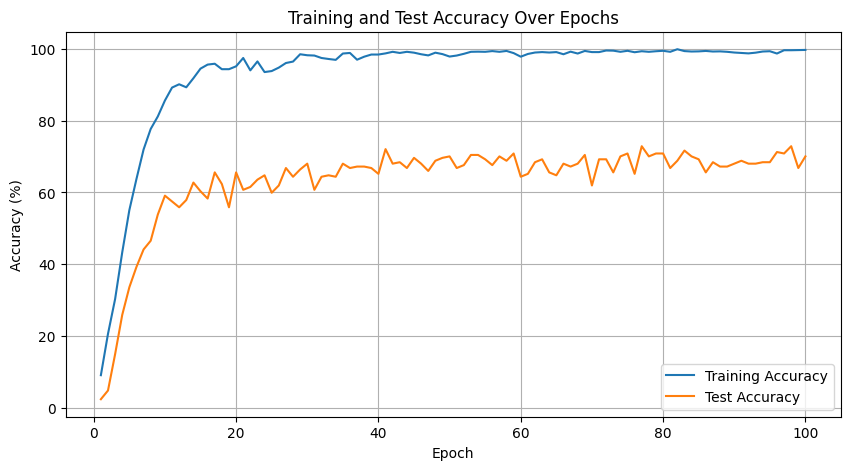

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# ResNet

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.LeakyReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample  # To match dimensions if needed

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Residual connection
        out = self.relu(out)
        return out

class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNNModel, self).__init__()
        self.in_channels = 32  # Reduced from 64

        # Initial convolution layer
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.3)  # Add dropout

        # Residual layers with fewer blocks
        self.layer1 = self._make_layer(32, layers=1)
        self.layer2 = self._make_layer(64, layers=1, stride=2)
        self.layer3 = self._make_layer(128, layers=1, stride=2)
        self.layer4 = self._make_layer(256, layers=1, stride=2)

        # Adaptive pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, out_channels, layers, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )
        layers_list = []
        layers_list.append(ResidualBlock(self.in_channels, out_channels, stride=stride, downsample=downsample))
        self.in_channels = out_channels
        return nn.Sequential(*layers_list)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.dropout(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x



input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)
input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)


train_loader = train_dataloader
test_loader = test_dataloader

# Training loop with testing
num_epochs = 100
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Evaluate on test dataset
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

Epoch [1/100], Training Loss: 4.8013, Training Accuracy: 12.24%
Epoch [1/100], Test Accuracy: 1.62%
Epoch [2/100], Training Loss: 3.8977, Training Accuracy: 21.48%
Epoch [2/100], Test Accuracy: 4.45%
Epoch [3/100], Training Loss: 3.3108, Training Accuracy: 27.84%
Epoch [3/100], Test Accuracy: 7.69%
Epoch [4/100], Training Loss: 2.9332, Training Accuracy: 34.72%
Epoch [4/100], Test Accuracy: 8.50%
Epoch [5/100], Training Loss: 2.5681, Training Accuracy: 39.08%
Epoch [5/100], Test Accuracy: 11.74%
Epoch [6/100], Training Loss: 2.2140, Training Accuracy: 46.76%
Epoch [6/100], Test Accuracy: 10.53%
Epoch [7/100], Training Loss: 1.9644, Training Accuracy: 52.24%
Epoch [7/100], Test Accuracy: 14.17%
Epoch [8/100], Training Loss: 1.6548, Training Accuracy: 61.20%
Epoch [8/100], Test Accuracy: 20.65%
Epoch [9/100], Training Loss: 1.3915, Training Accuracy: 67.00%
Epoch [9/100], Test Accuracy: 24.70%
Epoch [10/100], Training Loss: 1.1602, Training Accuracy: 74.20%
Epoch [10/100], Test Accuracy:

In [ ]:
max_test_accuracy = max(test_accuracies)

# Find the index (epoch) where the maximum test accuracy occurs
max_index = test_accuracies.index(max_test_accuracy)
print(max_test_accuracy)
print(max_index)

66.39676113360325
45


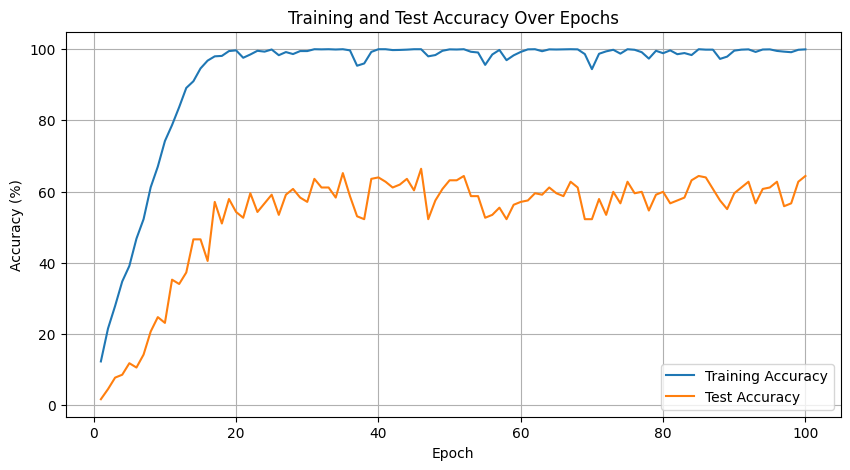

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# ConvNext

In [ ]:
import torch
import torch.nn as nn

class ConvNeXtBlock1D(nn.Module):
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super(ConvNeXtBlock1D, self).__init__()
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)  # Depthwise Conv
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # Pointwise Conv 1 (implemented as Linear)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)  # Pointwise Conv 2
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        input = x  # x shape: [batch_size, channels, length]

        x = self.dwconv(x) 

        x = x.permute(0, 2, 1) 

        x = self.norm(x)  

        x = self.pwconv1(x)  
        x = self.act(x)
        x = self.pwconv2(x)  

        if self.gamma is not None:
            x = self.gamma * x  
        x = self.drop_path(x) 
        x = x + input.permute(0, 2, 1)  

        x = x.permute(0, 2, 1)
        return x
    
class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample"""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        # Work with 3D tensors: [batch_size, length, channels]
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # Broadcast along dimensions
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # Binary mask
        output = x.div(keep_prob) * random_tensor
        return output


class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes, depths=[3, 3, 9, 3], dims=[64, 128, 256, 512], drop_path_rate=0.0):
        super(CNNModel, self).__init__()

        # Stem Layer
        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv1d(1, dims[0], kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(dims[0])
        )
        self.downsample_layers.append(stem)

        # Downsampling Layers
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm1d(dims[i]),
                nn.Conv1d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        # Stochastic Depth Decay Rule
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        # Stages
        self.stages = nn.ModuleList()
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock1D(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        # Final LayerNorm and Classification Head
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # Apply after global pooling
        self.head = nn.Linear(dims[-1], num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: [batch_size, 1, length]
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        # Global Average Pooling
        x = x.mean(-1)  # x shape: [batch_size, channels]
        x = self.norm(x)
        x = self.head(x)
        return x





input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)
input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes, drop_path_rate=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


train_loader = train_dataloader
test_loader = test_dataloader

# Training loop with testing
num_epochs = 100
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Evaluate on test dataset
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

Epoch [1/100], Training Loss: 3.7672, Training Accuracy: 23.20%
Epoch [1/100], Test Accuracy: 20.65%
Epoch [2/100], Training Loss: 2.4757, Training Accuracy: 39.64%
Epoch [2/100], Test Accuracy: 27.53%
Epoch [3/100], Training Loss: 1.9877, Training Accuracy: 48.24%
Epoch [3/100], Test Accuracy: 39.27%
Epoch [4/100], Training Loss: 1.6184, Training Accuracy: 55.64%
Epoch [4/100], Test Accuracy: 39.68%
Epoch [5/100], Training Loss: 1.3817, Training Accuracy: 62.20%
Epoch [5/100], Test Accuracy: 47.37%
Epoch [6/100], Training Loss: 1.0656, Training Accuracy: 71.36%
Epoch [6/100], Test Accuracy: 45.75%
Epoch [7/100], Training Loss: 0.7692, Training Accuracy: 77.96%
Epoch [7/100], Test Accuracy: 46.96%
Epoch [8/100], Training Loss: 0.5515, Training Accuracy: 85.60%
Epoch [8/100], Test Accuracy: 38.46%
Epoch [9/100], Training Loss: 0.3644, Training Accuracy: 91.64%
Epoch [9/100], Test Accuracy: 57.49%
Epoch [10/100], Training Loss: 0.1710, Training Accuracy: 97.40%
Epoch [10/100], Test Accur

In [ ]:
max_test_accuracy = max(test_accuracies)

# Find the index (epoch) where the maximum test accuracy occurs
max_index = test_accuracies.index(max_test_accuracy)
print(max_test_accuracy)
print(max_index)

71.65991902834008
55


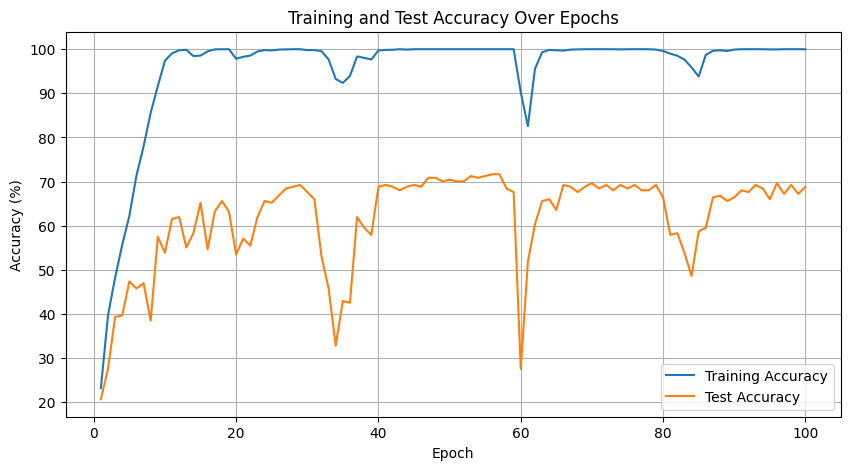

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# ConvNext with attention mechanism

In [ ]:
import torch
import torch.nn as nn

class ConvNeXtBlock1D(nn.Module):
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super(ConvNeXtBlock1D, self).__init__()
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)  # Depthwise Conv
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # Pointwise Conv 1 (implemented as Linear)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)  # Pointwise Conv 2
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        input = x  # x shape: [batch_size, channels, length]

        x = self.dwconv(x) 

        x = x.permute(0, 2, 1) 

        x = self.norm(x)  

        x = self.pwconv1(x)  
        x = self.act(x)
        x = self.pwconv2(x)  

        if self.gamma is not None:
            x = self.gamma * x  
        x = self.drop_path(x) 
        x = x + input.permute(0, 2, 1)  

        x = x.permute(0, 2, 1)
        return x
    
class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample"""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        # Work with 3D tensors: [batch_size, length, channels]
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # Broadcast along dimensions
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # Binary mask
        output = x.div(keep_prob) * random_tensor
        return output


class AttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super(AttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
    
    def forward(self, x):
        # x shape: [batch_size, channels, length]
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, length, channels]
        x, _ = self.attention(x, x, x)  # Self-attention
        x = x.permute(0, 2, 1)  # Reshape back to [batch_size, channels, length]
        return x

class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes, depths=[3, 3, 9, 3],
                 dims=[64, 128, 256, 512], drop_path_rate=0.0, num_heads=8):
        super(CNNModel, self).__init__()

        self.downsample_layers = nn.ModuleList()
        # Stem Layer
        stem = nn.Sequential(
            nn.Conv1d(1, dims[0], kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(dims[0])
        )
        self.downsample_layers.append(stem)

        # Downsampling Layers
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm1d(dims[i]),
                nn.Conv1d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        # Stochastic Depth Decay Rule
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        # Stages
        self.stages = nn.ModuleList()
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock1D(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        # Attention Block
        self.attention_block = AttentionBlock(dim=dims[-1], num_heads=num_heads)

        # Final LayerNorm and Classification Head
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = nn.Linear(dims[-1], num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: [batch_size, 1, length]
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Attention Block
        x = self.attention_block(x)  # Apply attention

        # Global Average Pooling
        x = x.mean(-1)  # x shape: [batch_size, channels]
        x = self.norm(x)
        x = self.head(x)
        return x






input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes, drop_path_rate=0.1)
input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


train_loader = train_dataloader
test_loader = test_dataloader

# Training loop with testing
num_epochs = 100
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Evaluate on test dataset
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

Epoch [1/100], Training Loss: 4.3493, Training Accuracy: 14.72%
Epoch [1/100], Test Accuracy: 2.83%
Epoch [2/100], Training Loss: 3.4565, Training Accuracy: 23.28%
Epoch [2/100], Test Accuracy: 9.72%
Epoch [3/100], Training Loss: 2.6587, Training Accuracy: 36.44%
Epoch [3/100], Test Accuracy: 18.22%
Epoch [4/100], Training Loss: 1.9565, Training Accuracy: 52.24%
Epoch [4/100], Test Accuracy: 26.72%
Epoch [5/100], Training Loss: 1.5585, Training Accuracy: 60.04%
Epoch [5/100], Test Accuracy: 30.36%
Epoch [6/100], Training Loss: 1.3502, Training Accuracy: 64.68%
Epoch [6/100], Test Accuracy: 31.17%
Epoch [7/100], Training Loss: 0.9896, Training Accuracy: 74.92%
Epoch [7/100], Test Accuracy: 34.01%
Epoch [8/100], Training Loss: 0.9792, Training Accuracy: 73.36%
Epoch [8/100], Test Accuracy: 34.01%
Epoch [9/100], Training Loss: 0.8481, Training Accuracy: 77.08%
Epoch [9/100], Test Accuracy: 34.01%
Epoch [10/100], Training Loss: 0.9962, Training Accuracy: 71.96%
Epoch [10/100], Test Accurac

In [ ]:
max_test_accuracy = max(test_accuracies)

# Find the index (epoch) where the maximum test accuracy occurs
max_index = test_accuracies.index(max_test_accuracy)
print(max_test_accuracy)
print(max_index)


34.0080971659919
6


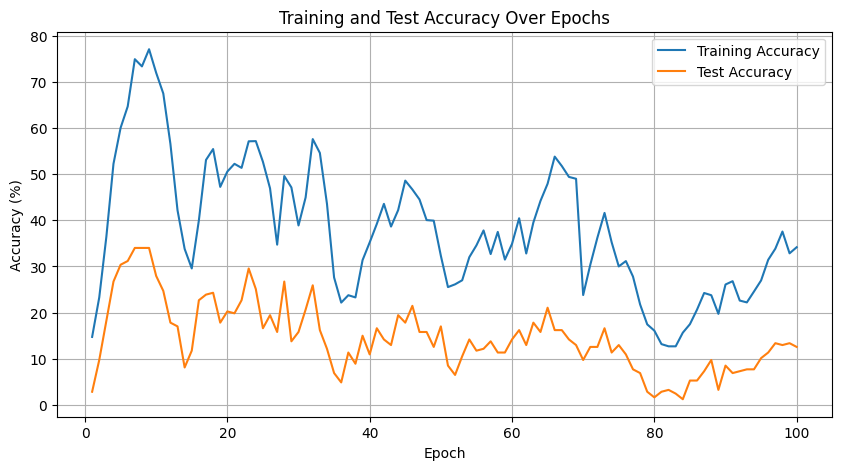

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()